In [ ]:
#https://www.kaggle.com/theblackmamba31/low-resolution-images-to-high-resolution
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Machine_Learning/GAN') 
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/GAN
data/            images_0.0002/                result_ISR/
div2k/           images_0.85/                  Single_ISR.ipynb
GAN_ISR.ipynb    ISR_Traininig_Tutorial.ipynb  super-resolution-master/
GAN_Tf_v2.ipynb  log_file                      weights/
images/          logs/


In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 480
high_img = []
path = 'div2k/DIV2K_train_HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '400.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = 'div2k/DIV2K_train_LR_bilinear'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '400.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 400/400 [02:42<00:00,  2.47it/s]


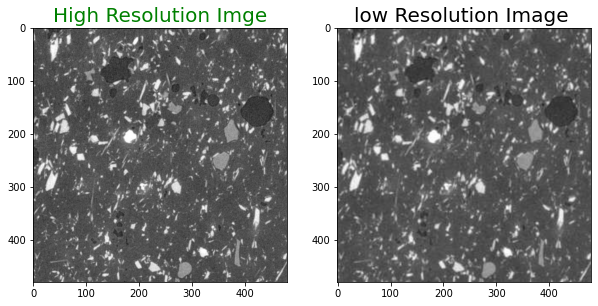

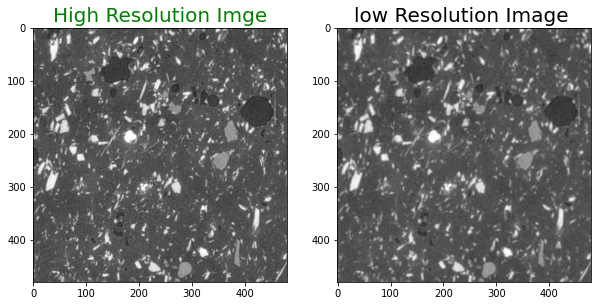

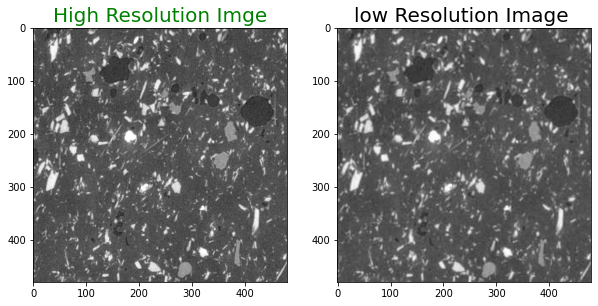

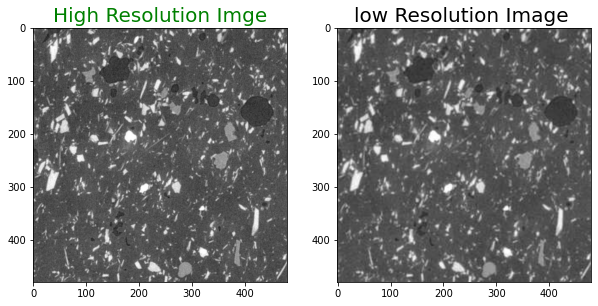

In [ ]:
for i in range(4):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[i])
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[i])

In [ ]:
train_high_image = high_img[:300]
train_low_image = low_img[:300]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))


test_high_image = high_img[300:]
test_low_image = low_img[300:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 240, 240, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 120, 120, 128 147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 60, 60, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), loss = 'mean_absolute_error', metrics = ['acc'])

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 200, batch_size = 32)

Epoch 1/200
10/10 [==============================] - 41s 793ms/step - loss: 0.6516 - acc: 0.5440
Epoch 2/200
10/10 [==============================] - 7s 648ms/step - loss: 0.2614 - acc: 0.3850
Epoch 3/200
10/10 [==============================] - 7s 652ms/step - loss: 0.0994 - acc: 0.2607
Epoch 4/200
10/10 [==============================] - 7s 650ms/step - loss: 0.0513 - acc: 0.3568
Epoch 5/200
10/10 [==============================] - 7s 659ms/step - loss: 0.0406 - acc: 0.1967
Epoch 6/200
10/10 [==============================] - 7s 659ms/step - loss: 0.0366 - acc: 0.2600
Epoch 7/200
10/10 [==============================] - 7s 650ms/step - loss: 0.0348 - acc: 0.2006
Epoch 8/200
10/10 [==============================] - 7s 653ms/step - loss: 0.0332 - acc: 0.1635
Epoch 9/200
10/10 [==============================] - 7s 653ms/step - loss: 0.0322 - acc: 0.1665
Epoch 10/200
10/10 [==============================] - 7s 643ms/step - loss: 0.0314 - acc: 0.1771
Epoch 11/200
10/10 [==================

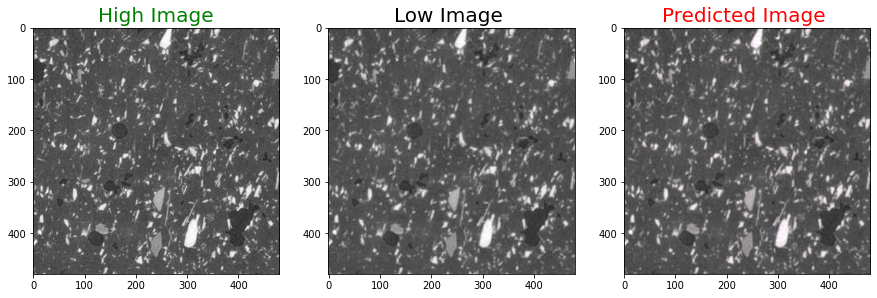

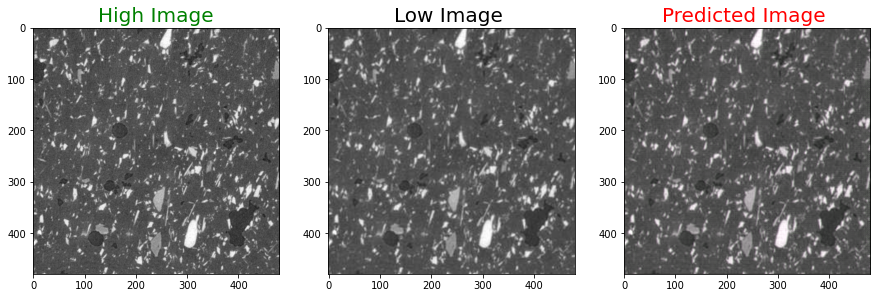

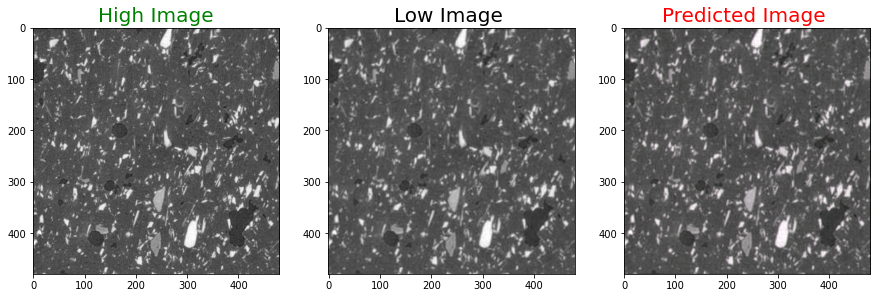

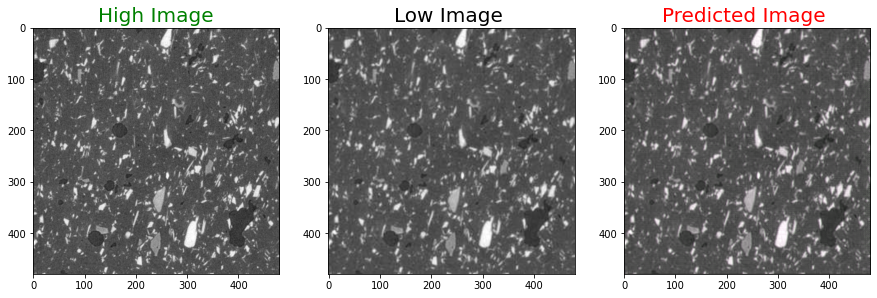

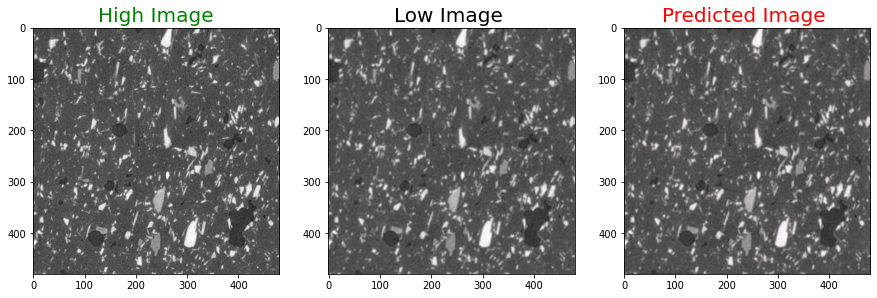

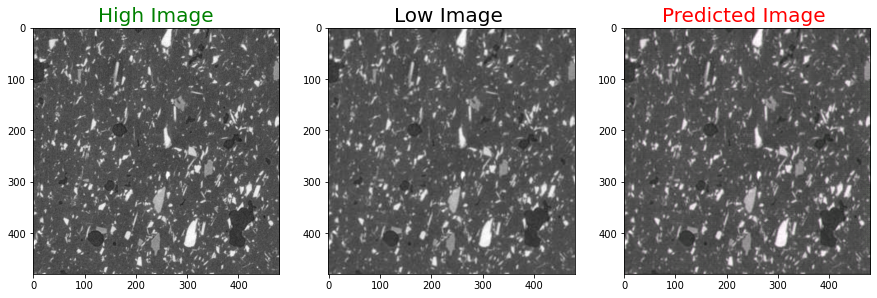

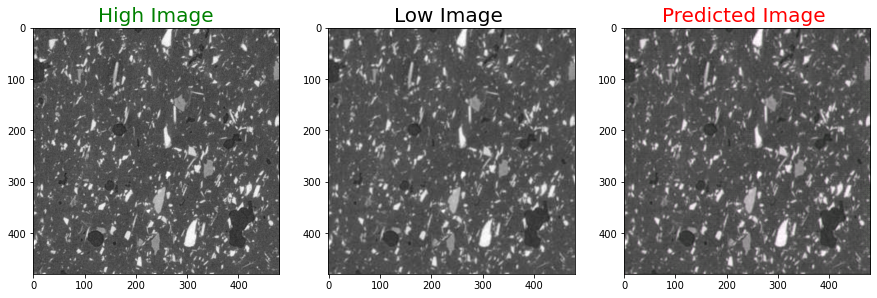

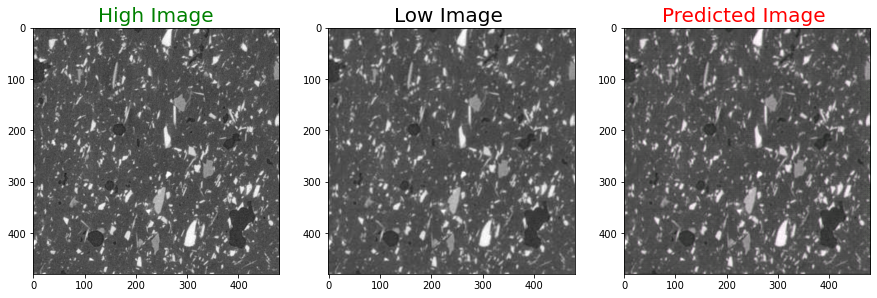

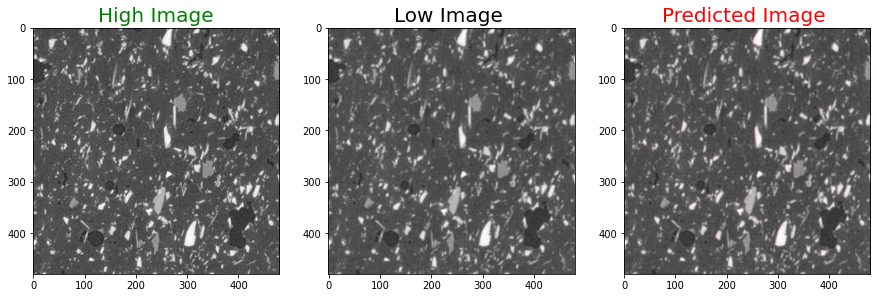

In [ ]:
def plot_images(high,low,predicted):    
    fig = plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

    save_fn = "result_ISR/" + 'Result_{:d}'.format(i+1) + '.jpg'
    fig.savefig(save_fn)

for i in range(1,10):
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [ ]:
#model.save("final_model.h5")